---

## Deep Learning Coding Project 3-4: Generative Adversarial Network

Before we start, please put your **Chinese** name and student ID in following format:

Name, 0000000000 // e.g.) 傅炜, 2021123123

YOUR ANSWER HERE

## Introduction

We will use Python 3, [NumPy](https://numpy.org/), and [PyTorch](https://pytorch.org/) packages for implementation. This notebook has been tested under the latest stable release version.

In this coding project, you will implement 2 generative models, i.e., energy-based model, (variational auto-encoder / generative adverserial network), to generate MNIST images.

**We will implement a generative adversarial network, specifically a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/abs/1511.06434) (DCGAN), in this notebook.**

In some cells and files you will see code blocks that look like this:

```Python
##############################################################################
#                  TODO: You need to complete the code here                  #
##############################################################################
raise NotImplementedError()
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################
```

You should replace `raise NotImplementedError()` with your own implementation based on the context, such as:

```Python
##############################################################################
#                  TODO: You need to complete the code here                  #
##############################################################################
y = w * x + b
##############################################################################
#                              END OF YOUR CODE                              #
##############################################################################

```

When completing the notebook, please adhere to the following rules:

+ Do not write or modify any code outside of code blocks
+ Do not add or delete any cells from the notebook.
+ Run all cells before submission. We will not re-run the entire codebook during grading.

**Finally, avoid plagiarism! Any student who violates academic integrity will be seriously dealt with and receive an F for the course.**

### Task

In this problem, you need to do class-conditioned generation on MNIST images by training a DCGAN. You should

1. **Complete the code of the generator $G : (z, y) → x$ and the discriminator $D : (x, y) → [0, 1]$.**

Both of them should be **fully convolutional networks (FCNs)** except for linear projection heads. For FCN, please refer to [this paper](https://arxiv.org/pdf/1411.4038.pdf) for details.

2. **Implement the training procedure.**

3. **Include necessary tricks applied in [DCGAN](https://arxiv.org/pdf/1511.06434.pdf).**

We present an example of generated images using DCGAN in the following cell.

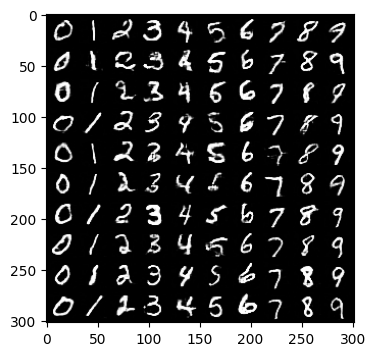

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 6, 4
plt.imshow(mpimg.imread('./gan/sample.png'))

### Submission

You need to submit your code (this notebook), your trained **generator** (named `./gan/gan_best.pth`), your generated images, and your report:

+ **Code**

Remember to run all the cells before submission. Remain your tuned hyperparameters unchanged.

+ **Generator**

In this notebook, we do not include codes to find the best model like the previous ones. You need to visualize generated images, manually select the best one, and save it as `./gan/gan_best.pth`. **Please do not submit any other checkpoints except for `./gan/gan_best.pth`!**

+ **Generated Images**

Please generate 100 images for each class (1000 in total), save it in `./gan/generated/`, and organize them as the following structure:

```
CodingProject3
├── ...
├── gan
│   ├── gan_best.pth
│   ├── generated
│       └── 0
│           ├── 0_00.png
│           ├── ...
│           ├── 0_99.png
│       └── 1
│           ├── 1_00.png
│           ├── ...
│           ├── 1_99.png
│       └── ...
│       └── 9
│           ├── 9_00.png
│           ├── ...
│           ├── 9_99.png
```

Specifially, you should name the $j$-th generated image of class $i$ as `{i}_{j}.png`, and save it into folder `./gan/generated/{i}/`. Check the `make_dataset` method of Generator for details.

+ **Report**

Please include the conditioned generation results (i.e., generated images in a $10\times 10$ array as above), the FID score, the standard deviation for each class, and other relevant statistics in your
report. Note that you only need to write a single report for this coding project.

### Grading

We will evaluate your model by **computing the [FID score](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance)**, as what we do for conditioned VAE.

In addition, the standard deviation of your generated images within
each class must **exceed a certain threshold**. Suppose the generated samples for
each class are of size (number of samples, 28, 28) with pixel values range
from 0 to 1, the standard deviation is given by `torch.std(samples, dim=0).mean()`. The thresholds for different digits are listed in the following table:

| Digit | 0    | 1    | 2    | 3    | 4    | 5    | 6    | 7    | 8    | 9    |
|-------|------|------|------|------|------|------|------|------|------|------|
| Threshold   | 0.17 | 0.08 | 0.17 | 0.15 | 0.14 | 0.16 | 0.15 | 0.13 | 0.15 | 0.13 |

### Tips

+ Monitoring the generated images in the training process. The quality of the samples helps judge the generator's ability to learn a diverse representation of the input data distribution.

+ See [here](https://developers.google.com/machine-learning/gan/problems) for tricks to prevent mode collapse.

+ Make sure your runs fine with the evaluation file in this notebook.

## Set Up Code

In [2]:
%load_ext autoreload
%autoreload 2

If you use Colab in this coding project, please uncomment the code, fill the `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` and run the following cells to mount your Google drive. Then, the notebook can find the required file (i.e., utils.py). If you run the notebook locally, you can skip the following cells.

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# import os

# # TODO: Fill in the Google Drive path where you uploaded the assignment
# # Example: If you create a 2022SP folder and put all the files under CP1 folder, then '2022SP/CP1'
# # GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2022SP/CP1'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None 
# GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
# print(os.listdir(GOOGLE_DRIVE_PATH))

In [5]:
# import sys
# sys.path.append(GOOGLE_DRIVE_PATH)

In [6]:
from utils import hello
hello()

Good luck!


Finally, please run the following cell to import some base classes for implementation (no matter whether you use colab).

In [7]:
from collections import deque
from torch.utils.data import DataLoader
from tqdm.autonotebook import tqdm

import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from utils import save_model, load_model, train_set, save_model_state_dict

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

/tmp/ipykernel_1188100/439044095.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Generator

Please implement your own generator module, which should be a fully convolutional network with linear projection heads.

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        self.label_size = label_size = 10
        self.latent_size = latent_size
        
        # Enhanced projection network with more layers and width
        self.proj = nn.Sequential(
            nn.Linear(latent_size + label_size, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 7*7*512),
        )

        # Deeper and wider convolutional transpose network
        self.conv_blocks = nn.Sequential(
            # Input: 512 channels, 7x7
            nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            # 512 channels, 14x14
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            # 256 channels, 28x28
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            # Final output layer
            nn.Conv2d(128, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                nn.init.normal_(m.weight, 0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight, 1.0, 0.02)
                nn.init.constant_(m.bias, 0)

    def forward(self, z, label):
        # One-hot encode the label
        y = F.one_hot(label, num_classes=self.label_size).float()
        
        # Concatenate latent vector with label
        x = torch.cat([z, y], dim=1)
        
        # Project and reshape
        x = self.proj(x)
        x = x.view(-1, 512, 7, 7)  # Changed to 512 channels
        
        # Convolutional blocks
        x = self.conv_blocks(x)
        
        return x

    @torch.no_grad()
    def sample_images(self, label, save=True, save_dir='./gan'):
        self.eval()
        n_samples = label.shape[0]
        samples = self(torch.randn(
            n_samples, self.latent_size).to(label.device), label)
        imgs = samples.view(n_samples, 1, 28, 28)
        if save:
            os.makedirs(save_dir, exist_ok=True)
            torchvision.utils.save_image(imgs, os.path.join(
                save_dir, 'sample.png'), nrow=int(np.sqrt(n_samples)))
        return imgs
    
    @torch.no_grad()
    def make_dataset(self, n_samples_per_class=10, save=True, save_dir='./gan/generated/'):
        self.eval()
        device = next(self.parameters()).device
        for i in range(self.label_size):
            label = i * torch.ones(n_samples_per_class, dtype=torch.long, device=device)
            samples = self(torch.randn(
                n_samples_per_class, self.latent_size).to(device), label)
            imgs = samples.view(n_samples_per_class, 1, 28, 28)
            print(f"Standard deviation of number {i}: {torch.std(imgs, dim=0).mean().item()}")
            if save:
                os.makedirs(os.path.join(save_dir, str(i)), exist_ok=True)
                for j in range(n_samples_per_class):
                    torchvision.utils.save_image(imgs[j], os.path.join(save_dir, str(i), "{}_{:>03d}.png".format(i, j)))


## Discriminator

Please implement your own discriminator module, which should also be a fully convolutional network with linear projection heads.

**Hint**: Pay attention to the shape of your output and the shape of label.

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.label_size = label_size = 10
        
        # Enhanced discriminator with more layers and channels
        self.conv_blocks = nn.Sequential(
            # Input: 1 (image) + 10 (label) channels
            nn.Conv2d(1 + label_size, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),  # Using instance norm instead of batch norm
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        # Final output layer (no sigmoid for WGAN)
        self.final = nn.Sequential(
            nn.Linear(512*3*3, 1),
            # No sigmoid for WGAN (using critic)
        )
        
        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.normal_(m.weight, 0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.InstanceNorm2d):
                if m.weight is not None:
                    nn.init.normal_(m.weight, 1.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, img, label):
        # One-hot encode the label and reshape
        y = F.one_hot(label, num_classes=self.label_size).float()
        y = y.view(-1, self.label_size, 1, 1)
        y = y.expand(-1, -1, img.shape[2], img.shape[3])
        
        # Concatenate image with label channels
        x = torch.cat((img, y), dim=1)
        
        # Feature extraction
        x = self.conv_blocks(x)
        x = x.view(x.shape[0], -1)
        
        # Final output (critic value)
        return self.final(x)


## Training

We have implemented the skeleton of train function. Please complete the missing loss computation part.

In [10]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples, labels, device):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), device=device)
    
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = discriminator(interpolates, labels)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates, device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [ ]:
def train(n_epochs, generator, discriminator, train_loader, optimizer_g, optimizer_d, 
          device=torch.device('cuda'), save_interval=10, lambda_gp=10, n_critic=5,
          parallel=False):
    
    generator.to(device)
    discriminator.to(device)

    for epoch in range(n_epochs):
        train_g_loss = train_d_loss = 0
        n_batches = 0
        pbar = tqdm(total=len(train_loader.dataset))
        for i, (x, y) in enumerate(train_loader):
            # compute loss
            n_batches += x.shape[0]
            x = x.to(device)
            y = y.to(device)
            ##############################################################################
            #                  TODO: You need to complete the code here                  #
            ##############################################################################
            # YOUR CODE HERE
            # Train Discriminator
            optimizer_d.zero_grad()
            latent_size = generator.latent_size
            z = torch.randn(x.size(0), latent_size).to(device)
            fake_imgs = generator(z, y)
            real_validity = discriminator(x, y)
            
            fake_validity = discriminator(fake_imgs.detach(), y)
            gradient_penalty = compute_gradient_penalty(discriminator, x, fake_imgs.detach(), y, device)
            
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
            d_loss.backward()
            optimizer_d.step()
            
            # Train Generator (every n_critic steps)
            if i % n_critic == 0:
                optimizer_g.zero_grad()
                z = torch.randn(x.size(0), latent_size, device=device)
                gen_imgs = generator(z, y)
                g_loss = -torch.mean(discriminator(gen_imgs, y))
                g_loss.backward()
                optimizer_g.step()
            ##############################################################################
            #                              END OF YOUR CODE                              #
            ##############################################################################

            train_g_loss += g_loss.sum().item()
            train_d_loss += d_loss.sum().item()

            pbar.update(x.size(0))
            pbar.set_description('Train Epoch {}, Generator Loss: {:.6f}, Discriminator Loss: {:.6f}'.format(
                epoch + 1, train_g_loss / n_batches, train_d_loss / n_batches))
        pbar.close()

        if (epoch + 1) % save_interval == 0:
            os.makedirs(f'./gan/{epoch + 1}', exist_ok=True)
            save_model(f'./gan/{epoch + 1}/gan.pth', generator, optimizer_g,
                       discriminator=discriminator, optimizer_d=optimizer_d)

            # sample and save images
            label = torch.arange(10).repeat(10).to(device)
            generator.sample_images(
                label, save=True, save_dir=f"./gan/{epoch + 1}/")


## Enjoy

Tune your hyperparameters and make your conditional DCGAN work. Good luck!

In [12]:
train_loader = DataLoader(train_set, batch_size=256, pin_memory=True,
                          drop_last=False, shuffle=True, num_workers=2)

g = Generator(100)
d = Discriminator()


optimizer_g = torch.optim.Adam(g.parameters(), lr=1e-4, betas=(0.5, 0.99))
optimizer_d = torch.optim.Adam(d.parameters(), lr=1e-4, betas=(0.5, 0.99))

Now you can start your training. Please keep in mind that this cell may **NOT** be run when we evaluate your assignment!

In [13]:
# # feel free to change training hyper-parameters!
# train(200, g, d, train_loader, optimizer_g, optimizer_d, device=device, parallel=False)

Generate samples. Make sure your code runs fine with the following cell!

In [ ]:
state_dict = load_model('./gan/200/gan.pth')[0]
g.load_state_dict(state_dict)
g.make_dataset(n_samples_per_class=100)

Standard deviation of number 0: 0.17484474182128906
Standard deviation of number 1: 0.08846233040094376
Standard deviation of number 2: 0.1781245619058609
Standard deviation of number 3: 0.16032159328460693
Standard deviation of number 4: 0.15749341249465942
Standard deviation of number 5: 0.17081329226493835
Standard deviation of number 6: 0.14800883829593658
Standard deviation of number 7: 0.15518543124198914
Standard deviation of number 8: 0.1682431548833847
Standard deviation of number 9: 0.14859631657600403


### Grading

We will evaluate your model by **computing the [FID score](https://en.wikipedia.org/wiki/Fr%C3%A9chet_inception_distance)**, as what we do for conditioned VAE.

In addition, the standard deviation of your generated images within
each class must **exceed a certain threshold**. Suppose the generated samples for
each class are of size (number of samples, 28, 28) with pixel values range
from 0 to 1, the standard deviation is given by `torch.std(samples, dim=0).mean()`. The thresholds for different digits are listed in the following table:

| Digit | 0    | 1    | 2    | 3    | 4    | 5    | 6    | 7    | 8    | 9    |
|-------|------|------|------|------|------|------|------|------|------|------|
| Threshold   | 0.17 | 0.08 | 0.17 | 0.15 | 0.14 | 0.16 | 0.15 | 0.13 | 0.15 | 0.13 |

## Evaluation

Make sure your code runs fine with the following cell!

In [17]:
!python evaluate_cgen.py --gan

/scorpio/home/liuhanzuo/.conda/envs/dl/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scorpio/home/liuhanzuo/.conda/envs/dl/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
evaluate_cgen.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/